In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
# from torchvision import datasets
from torchvision import io
import cv2
import PIL
from torchvision.transforms import ToTensor,Compose,Resize,Normalize,InterpolationMode, RandomHorizontalFlip,RandomRotation
from torchvision.models import vgg16
from torchvision.models import VGG16_Weights
from torch import nn
from torch.nn import functional as F
from dataclasses import dataclass
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from torch.nn import *
import albumentations as A
# from transformers import DPTFeatureExtractor, DPTForSemanticSegmentation
from PIL import Image,ImageOps
import gc
import requests

In [5]:
# !pip install efficientnet-pytorch
import numpy

In [6]:
!pip install -q -U segmentation-models-pytorch albumentations

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [8]:
import torchvision
import torch.nn as nn
import segmentation_models_pytorch as smp
# from efficientnet_pytorch import EfficientNet

In [9]:
import os

class CustomDataset(Dataset):
    def __init__(self, images_dir, masks_dir):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transforms=Compose([ToTensor(),Resize((256, 256),interpolation=InterpolationMode.NEAREST,antialias=True), Normalize(mean = (0.485, 0.456, 0.406), std = (0.229, 0.224, 0.225))])
        self.mask_trans=Resize((256, 256),interpolation=InterpolationMode.NEAREST,antialias=True)
        self.trans=A.Compose([A.HorizontalFlip(p =0.5),A.VerticalFlip(p = 0.5),A.ShiftScaleRotate(shift_limit=(-0.2, 0.2), scale_limit=(1,1.5), rotate_limit=90, p=0.5)], is_check_shapes=False)
        self.image_names = os.listdir(images_dir)
        self.mask_names = os.listdir(masks_dir)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):

        image_name = self.image_names[idx]
        image_path = os.path.join(self.images_dir, image_name)
        image = Image.open(image_path)
        mask_name = image_name[:-4] + '_mask.png'

        mask_path = os.path.join(self.masks_dir, mask_name)
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path)
        new= self.trans(image=image, mask=mask)
        image=new['image']
        mask=new['mask']
        image=self.transforms(image)
        mask=self.transforms(mask)
        mask=mask[0]
        mask=mask/255.0
        mask=(mask > 0)
        mask.unsqueeze(0)
        mask.squeeze(0)
        mask=mask.to(torch.long)
#         print(image.shape)
#         print(mask.shape)
        return image, mask

# Example usage
# transform = Compose([
#     Resize((256, 256)),
#     RandomHorizontalFlip(),
#     RandomRotation(degrees=30),
#     ToTensor(),  # Convert both image and mask to tensors
#     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

images_dir = '/kaggle/input/new-images'
masks_dir = '/kaggle/input/new-masks'

dataset = CustomDataset(images_dir=images_dir, masks_dir=masks_dir)

In [12]:
from torch.utils.data import random_split
batch_size=12
validation_split = 0.1  # 20% of the data for validation
dataset_size = len(dataset)
val_size = int(validation_split * dataset_size)
train_size = dataset_size - val_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [13]:
print(len(train_dataloader))
print(len(val_dataloader))

3
1


tensor(0)
tensor(1)


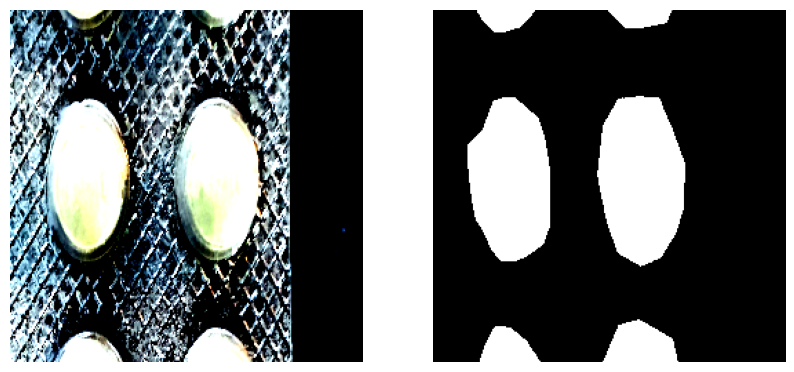

tensor(0)
tensor(1)


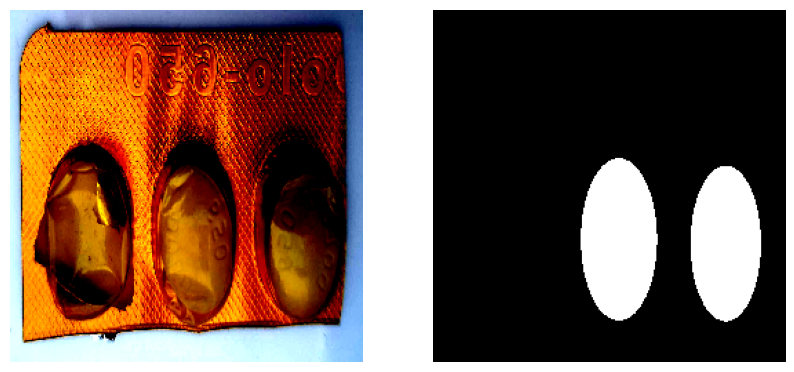

tensor(0)
tensor(1)


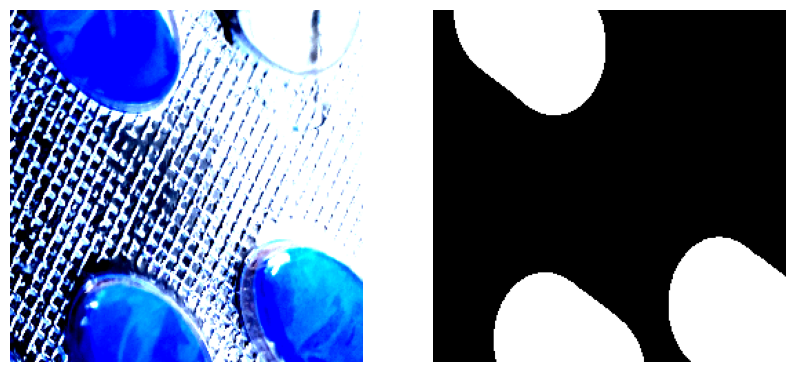

tensor(0)
tensor(0)


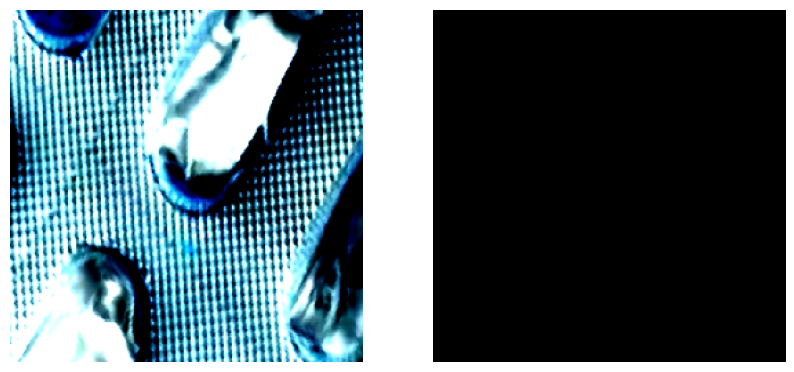

tensor(0)
tensor(1)


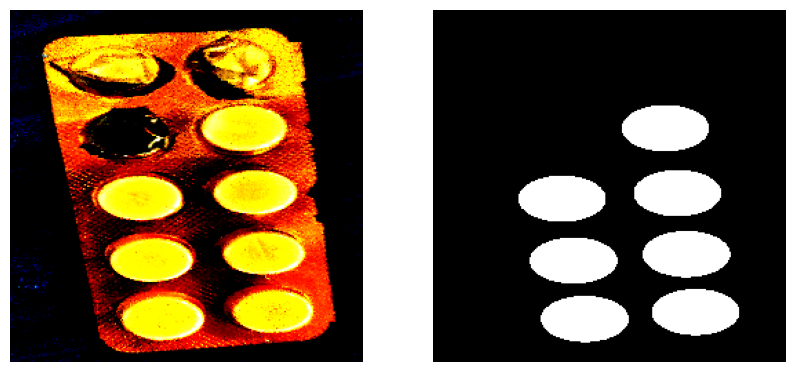

tensor(0)
tensor(0)


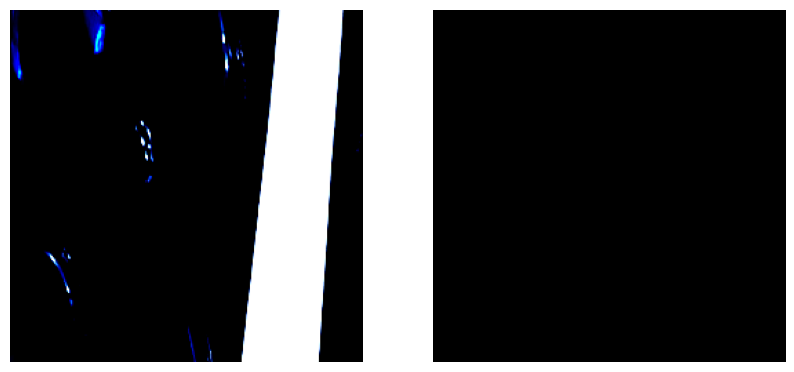

tensor(0)
tensor(1)


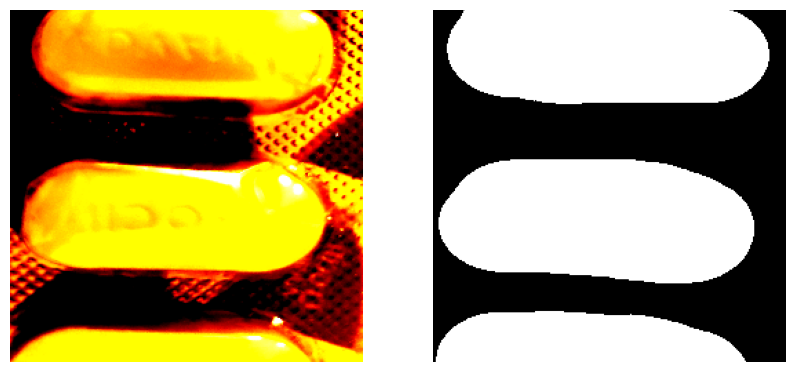

tensor(0)
tensor(1)


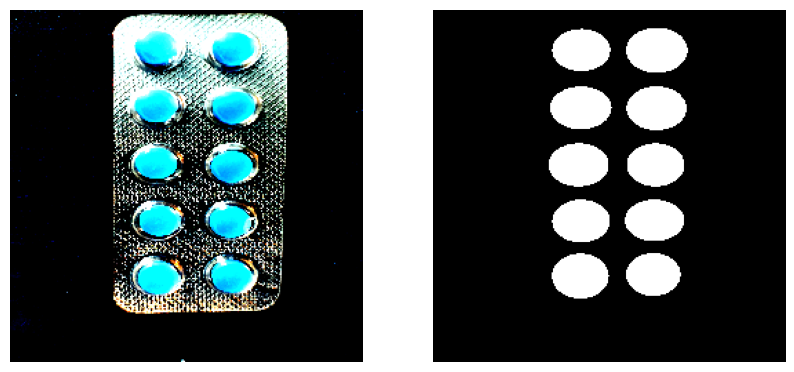

tensor(0)
tensor(1)


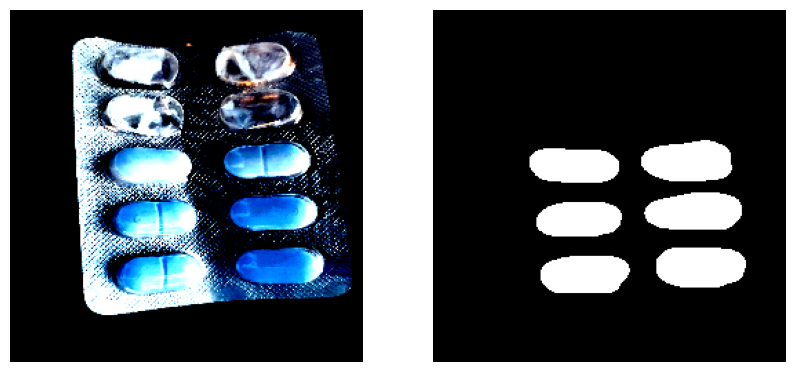

tensor(0)
tensor(1)


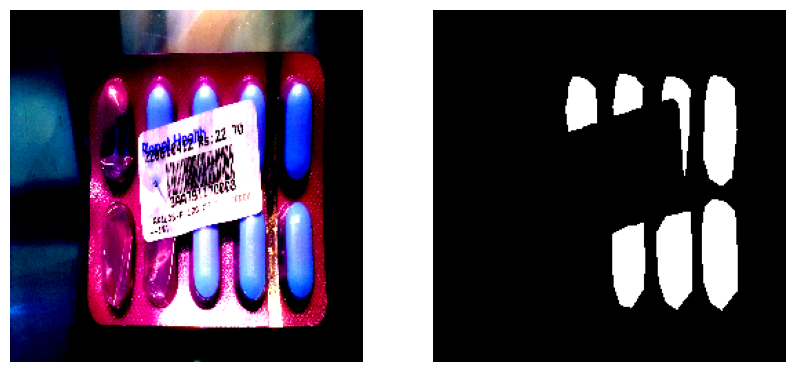

tensor(0)
tensor(1)


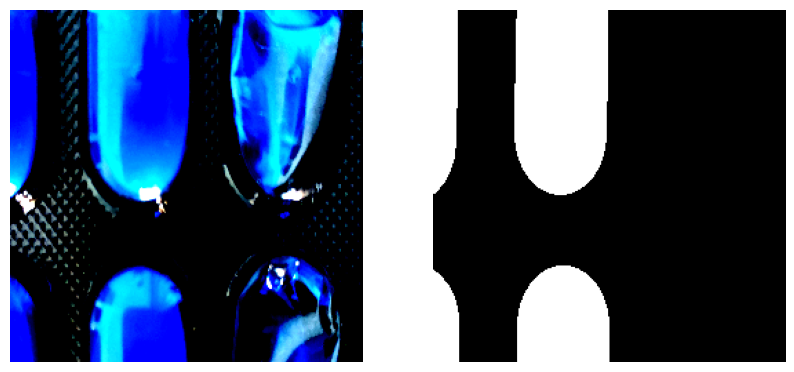

tensor(0)
tensor(1)


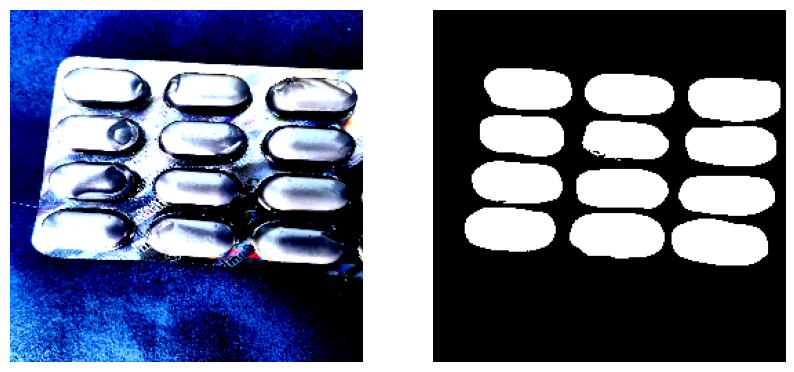

tensor(0)
tensor(1)


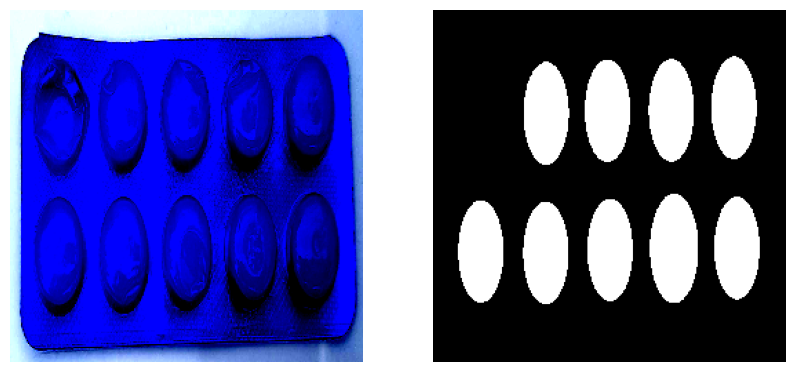

tensor(0)
tensor(1)


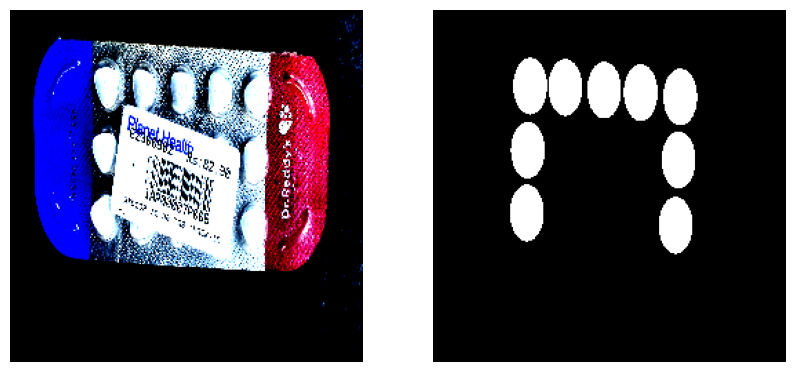

tensor(0)
tensor(1)


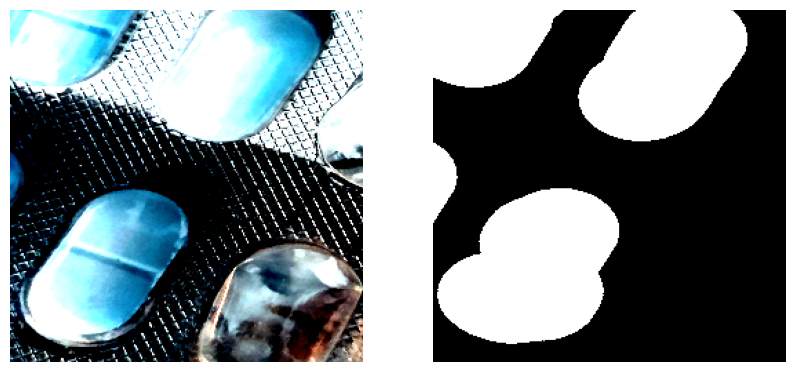

tensor(0)
tensor(1)


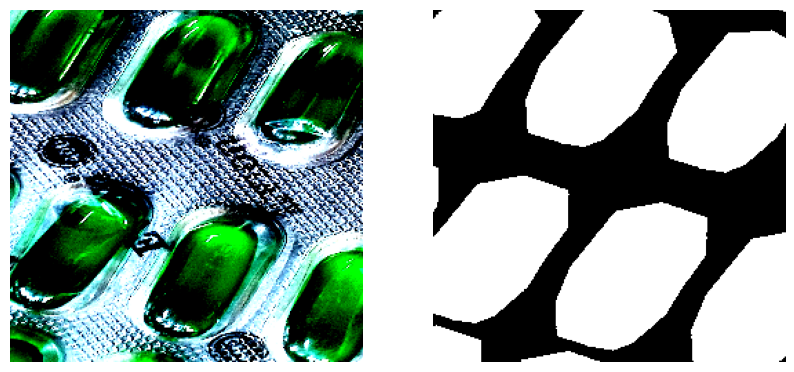

tensor(0)
tensor(1)


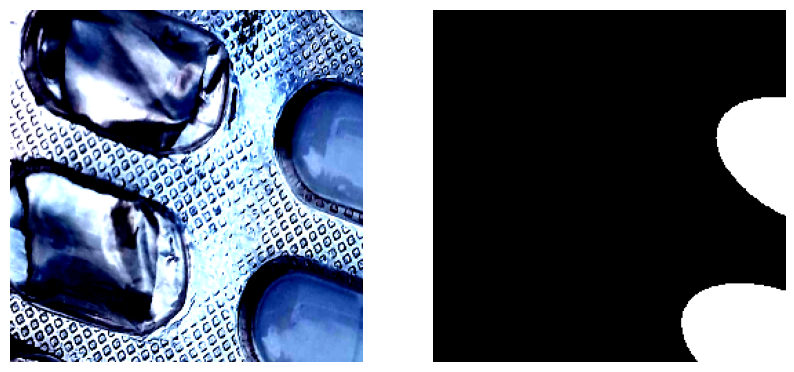

tensor(0)
tensor(1)


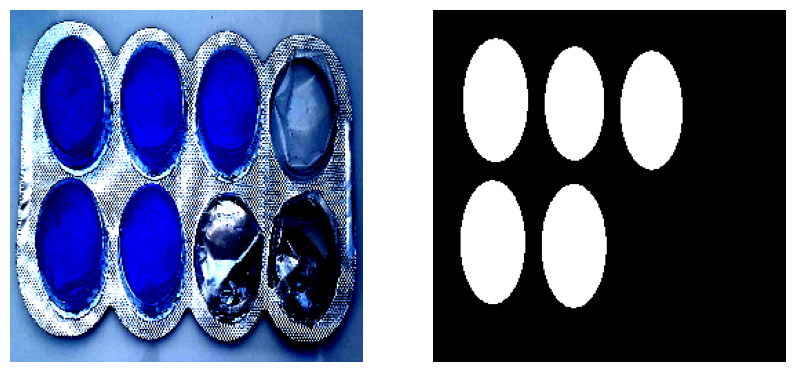

tensor(0)
tensor(1)


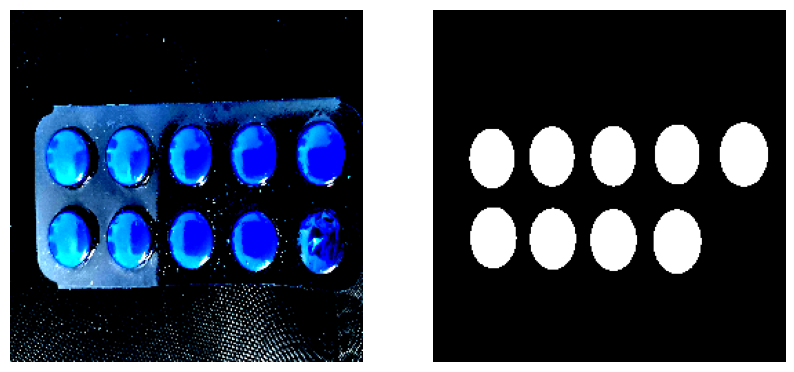

tensor(0)
tensor(1)


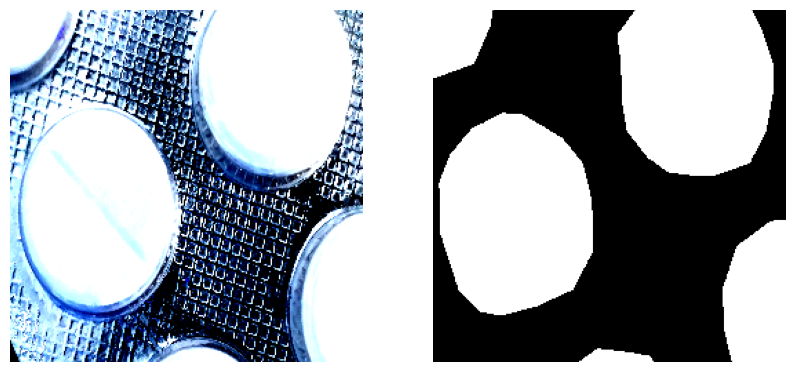

tensor(0)
tensor(1)


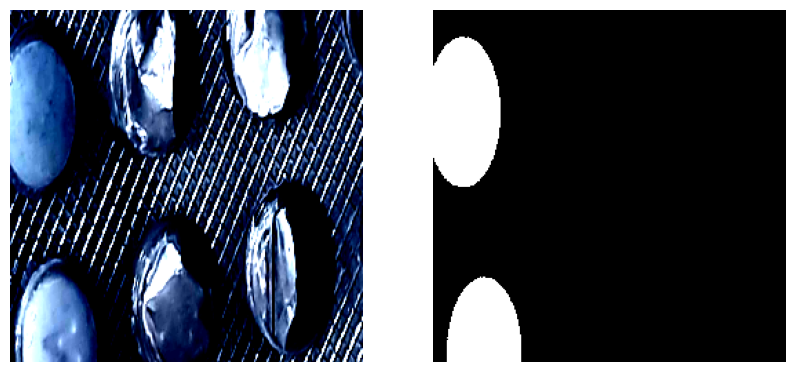

tensor(0)
tensor(1)


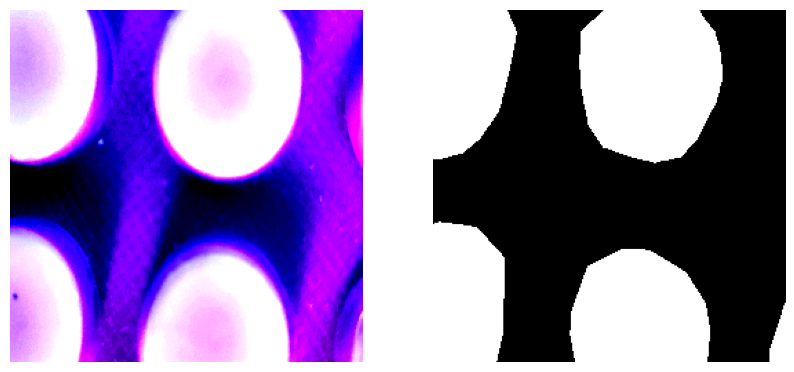

tensor(0)
tensor(1)


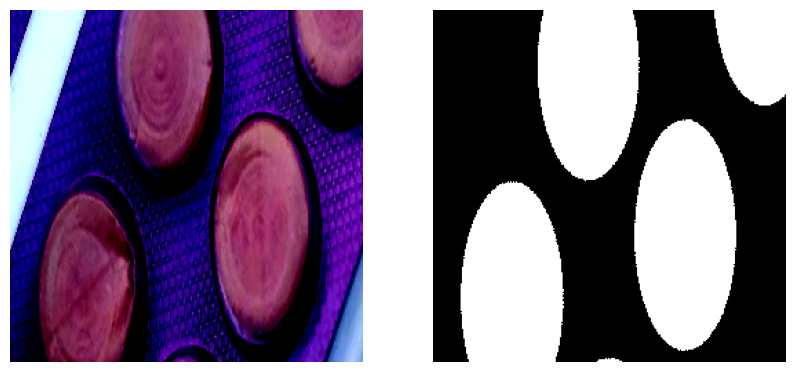

tensor(0)
tensor(1)


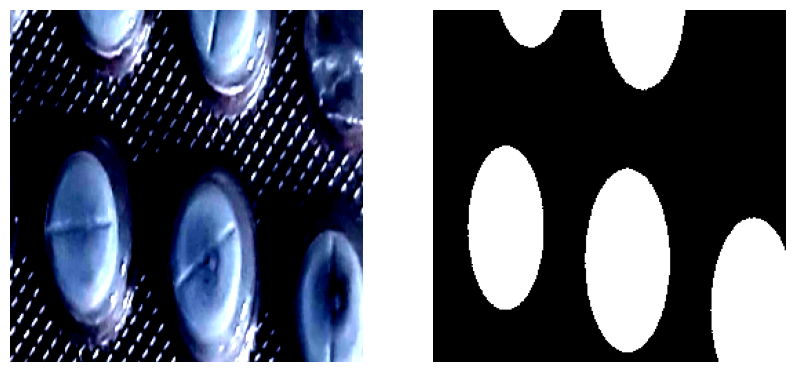

tensor(0)
tensor(1)


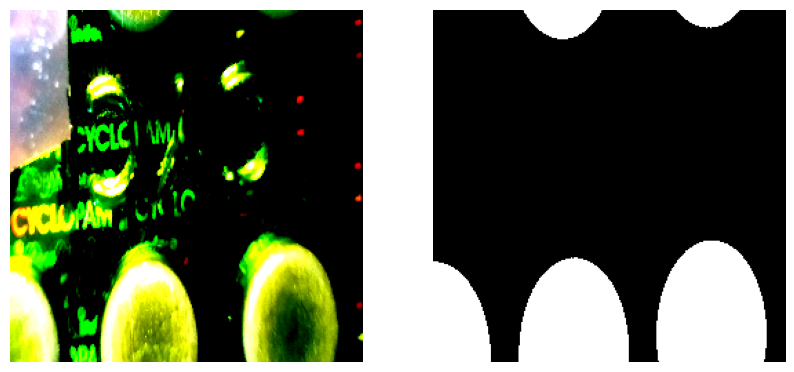

tensor(0)
tensor(1)


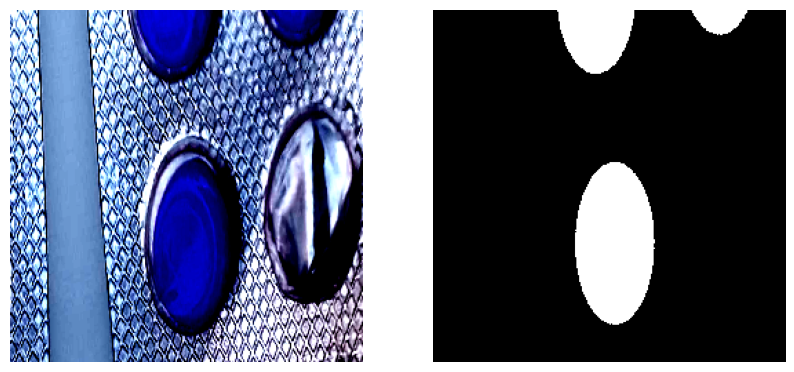

tensor(0)
tensor(0)


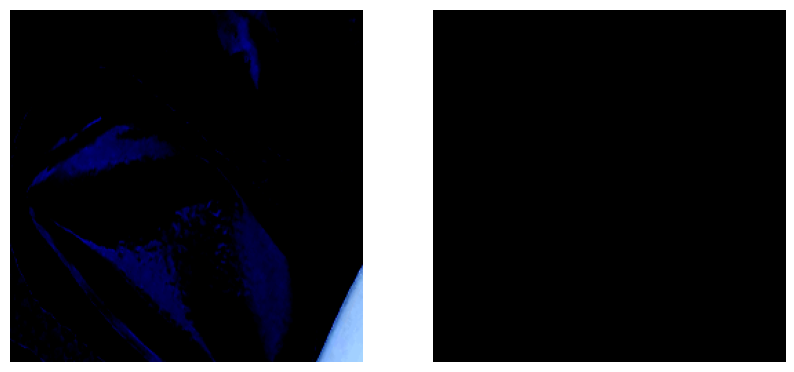

In [14]:
for i, (b_image, b_mask) in enumerate(train_dataloader):
  for i in range(b_image.shape[0]):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(b_image[i].permute(1,2,0))
    axes[0].axis('off')
    print(torch.min(b_mask[i]))
    print(torch.max(b_mask[i]))
    axes[1].imshow(b_mask[i], cmap='gray')
    axes[1].axis('off')
    plt.show()


In [15]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models

class BinaryDeepLab(nn.Module):
    def __init__(self):
        super(BinaryDeepLab, self).__init__()
        # Load DeepLabv3 model
        self.deeplab = models.segmentation.deeplabv3_resnet101(pretrained=True)
        # Modify the last layer to output a single channel
        self.deeplab.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)
        # Apply sigmoid activation function
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.deeplab(x)['out']
        x = self.sigmoid(x)
        return x

# Example usage
model = BinaryDeepLab()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:02<00:00, 87.9MB/s] 


In [16]:
def train(model, train_loader, loss_fn, optimizer):
    model.train()
    total_loss = 0
    total_dice_acc = 0
    
    for i, (data, target) in enumerate(train_loader):
        print("Batch: ",i )
        optimizer.zero_grad()
        pred = model(data)
        pred = pred.squeeze(1)
        target =target.float()
#         print(pred.squeeze(1).shape, pred.dtype)
#         print(target.shape, target.dtype)
        loss = loss_fn(pred.float(), target.float())
        loss.backward()
        optimizer.step()
        pred_class=(pred >= 0.5).long()
        target=target.long()
        intersection = torch.sum(pred_class * target)
        union = torch.sum(pred_class) + torch.sum(target)
        dice_coeff = (2. * intersection) / (union + 1e-8)  # Adding epsilon to avoid division by zero
        total_dice_acc += dice_coeff.item()

        total_loss += loss.item()
        print("Batch Loss:", loss)
        print("Batch Dice Accuracy:", dice_coeff)
        
    avg_loss = total_loss / len(train_loader)
    avg_dice_acc = total_dice_acc / len(train_loader)
    
    print("Epoch", i, "Loss:", avg_loss)
    print("Epoch", i, " Dice Accuracy:", avg_dice_acc)
    
    return avg_loss, avg_dice_acc


In [17]:
model.deeplab.requires_grad_=False
model.deeplab.classifier[3].requires_grad_= True
model.deeplab.classifier[4].requires_grad_= True

In [22]:
class DicePlusBCELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.bce_loss = nn.functional.binary_cross_entropy

    def forward(self, inputs, targets, smooth=1):
        BCE_loss = self.bce_loss(inputs, targets)

        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs*targets).sum()
#         print(intersection)
#         print(inputs)
#         print(targets)
        dice_coeff = (2*intersection+smooth)/(inputs.sum() + targets.sum() + smooth)
        dice_loss = 1 - dice_coeff

        loss = dice_loss + BCE_loss
#         loss = dice_loss
        return loss

In [25]:
loss_fn=DicePlusBCELoss()
optim=torch.optim.Adam(model.parameters(),lr=0.001)
epochs=15
for i in range(epochs):
  print(train(model, train_dataloader, loss_fn, optim))

Batch:  0
Batch Loss: tensor(0.8543, grad_fn=<AddBackward0>)
Batch Dice Accuracy: tensor(0.7995)
Batch:  1
Batch Loss: tensor(0.9572, grad_fn=<AddBackward0>)
Batch Dice Accuracy: tensor(0.6950)
Batch:  2
Batch Loss: tensor(1.0738, grad_fn=<AddBackward0>)
Batch Dice Accuracy: tensor(0.6060)
Epoch 2 Loss: 0.9617464939753214
Epoch 2  Dice Accuracy: 0.7001579801241556
(0.9617464939753214, 0.7001579801241556)
Batch:  0
Batch Loss: tensor(1.0072, grad_fn=<AddBackward0>)
Batch Dice Accuracy: tensor(0.6393)
Batch:  1
Batch Loss: tensor(0.9760, grad_fn=<AddBackward0>)
Batch Dice Accuracy: tensor(0.7023)
Batch:  2
Batch Loss: tensor(0.9176, grad_fn=<AddBackward0>)
Batch Dice Accuracy: tensor(0.7505)
Epoch 2 Loss: 0.9669083754221598
Epoch 2  Dice Accuracy: 0.6973761717478434
(0.9669083754221598, 0.6973761717478434)
Batch:  0
Batch Loss: tensor(0.9157, grad_fn=<AddBackward0>)
Batch Dice Accuracy: tensor(0.7316)
Batch:  1
Batch Loss: tensor(0.9816, grad_fn=<AddBackward0>)
Batch Dice Accuracy: tenso

KeyboardInterrupt: 

DICEPLUSBCELOSS

torch.Size([2, 1, 256, 256])
tensor(0.0051, grad_fn=<MinBackward1>)
tensor(1.0000, grad_fn=<MaxBackward1>)
tensor(0)
tensor(255)
tensor(0)
tensor(255)


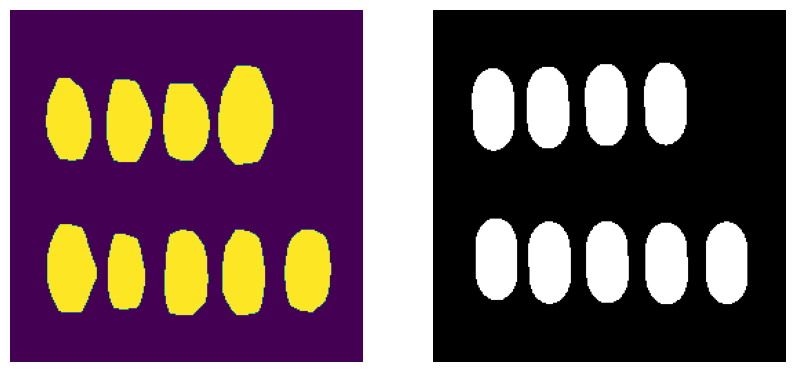

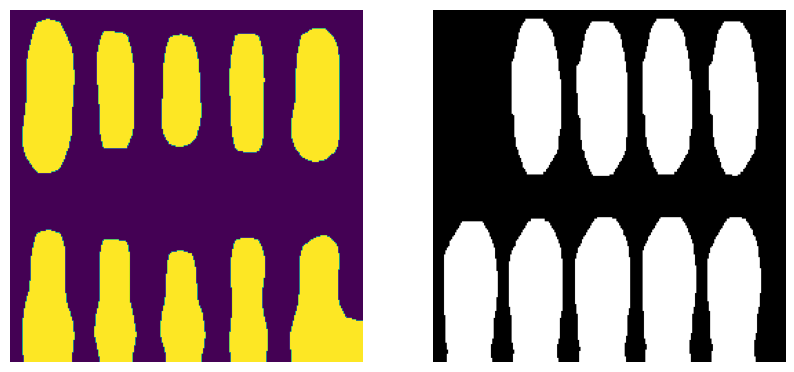

In [24]:
model.eval()
for i, (b_image, b_mask) in enumerate(val_dataloader):
    pred=model(b_image)
    print(pred.shape)
    print(torch.min(pred))
    print(torch.max(pred))
    pred = torch.where(pred > 0.5, 255, 0)
    for i in range(b_image.shape[0]):
        fig, axes = plt.subplots(1, 2, figsize=(10, 5 ))
        axes[0].imshow(pred[i].squeeze(0))
        axes[0].axis('off')
        print(torch.min(pred[i]))
        print(torch.max(pred[i]))
        axes[1].imshow(b_mask[i], cmap='gray')
        axes[1].axis('off')
        
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
pred_mask=(pred >= 0.5).long()
# pred_mask=pred_mask[1]
print(inp[0].shape)
print(pred_mask.shape)
plt.imshow(inp[0].permute(1,2,0))
plt.show()
plt.imshow(pred_mask.squeeze(0))
plt.show()
plt.imshow(mask[0].squeeze(1))
plt.show()